# Imports

In [34]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

from tensorflow import keras
from tensorflow.keras import layers
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(tf.config.experimental.list_physical_devices('GPU'))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2023-01-13 18:33:51.041577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 18:33:51.041978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 18:33:51.042224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 18:33:51.042677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 18:33:51.042976: I tensorflow/compiler/xla/stream_executo

# Load dataset (single frame human pose)

In [35]:
X=[]
y=[]
X_test = []
y_test = []

folders = ["alcaraz", "dimitrov_alcaraz", "dimitrov_thiem", "roland"]
for folder in folders:
    if not os.path.exists(f"dataset/{folder}/shots/"):
        print(f"dataset/{folder}/shots/ doesnt exist")
        continue
        
    print(f"Loading shots from dataset/{folder}/shots/")
        
    for shot_csv in tqdm(sorted(os.listdir(f'dataset/{folder}/shots/'))):
        data = pd.read_csv(os.path.join(f'dataset/{folder}/shots/', shot_csv))
        
        if folder == "nadal":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data
            
        data_train = data[:int(0.8*len(data))]
        data_test = data[int(0.8*len(data)):]

        #print(f"{len(data_train)} for training and {len(data_test)} for test")

        #print(list(data_train.loc[:, data.columns != 'shot'].to_numpy()))
        features_train = list(data_train.loc[:, data.columns != 'shot'].to_numpy())
        features_test = list(data_test.loc[:, data.columns != 'shot'].to_numpy())
        
        #print(features_train)

        X.extend(features_train)
        y.extend(data_train["shot"].to_numpy().flatten())

        X_test.extend(features_test)
        y_test.extend(data_test["shot"].to_numpy().flatten())
        
    

X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

y_test = np.array(y_test)

print(f"Loaded {len(y)} shots for training")
print(f"Loaded {len(y_test)} shots for test")
    

Loading shots from dataset/alcaraz/shots/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 718.93it/s]


Loading shots from dataset/dimitrov_alcaraz/shots/


0it [00:00, ?it/s]


Loading shots from dataset/dimitrov_thiem/shots/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 717.16it/s]


Loading shots from dataset/roland/shots/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 712.42it/s]

Loaded 8064 shots for training
Loaded 2016 shots for test


# Shot shots proportion in dataset

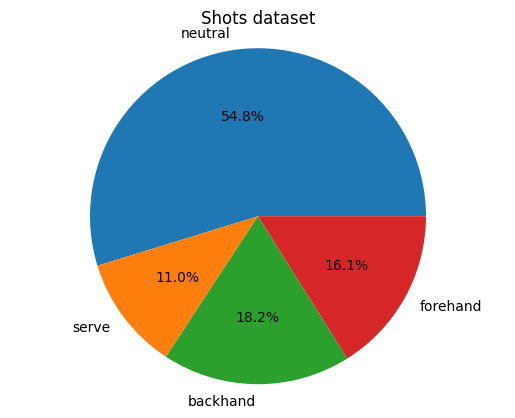

In [36]:
# if using a Jupyter notebook, include:
%matplotlib inline

shots = list(set(y))
occurences = [np.count_nonzero(y == shot) for shot in shots]
#print(shots, occurences)

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')


plt.show()

# Equalize classes repartition

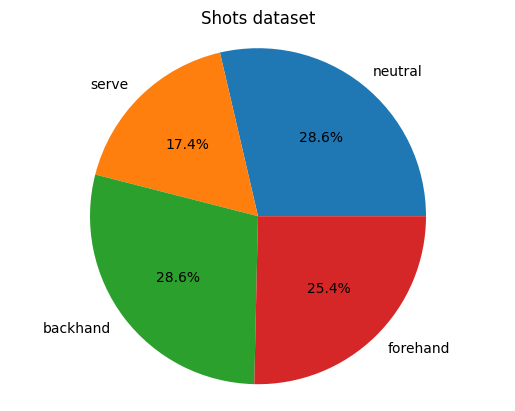

In [20]:
# Take backhand occurences and cap all other classes to this value

target_occurences_per_class = np.count_nonzero(y == "backhand")
subset_indices = []
for shot in shots:
    indices = np.argwhere(y == shot)
    size_subset = min(target_occurences_per_class, len(indices))
    assert(len(indices)>= size_subset)
    subset_indices.extend((np.random.choice(indices[:, 0], size=size_subset)))
    
subset_indices = np.sort(subset_indices)

y = y[subset_indices]
X = X[subset_indices]

occurences = [np.count_nonzero(y == shot) for shot in shots]

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')


plt.show()


# Make training/validation datasets

In [37]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle= False)



print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")


print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (26,)
Shape of val features : (26,)
Total categories:  4
Total categories:  4


In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)

y_val = np.array(y_val)
X_val = np.array(X_val)

y_test = np.array(y_test)
X_test = np.array(X_test)

In [39]:
print(list(le.classes_))

['backhand', 'forehand', 'neutral', 'serve']


In [40]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (5402, 26)
X_val Shape:  (2662, 26)
X_test Shape:  (2016, 26)
y_train Shape:  (5402, 4)
y_val Shape:  (2662, 4)
y_test Shape:  (2016, 4)


# Build fully connected layers network

In [41]:
m1=Sequential()
m1.add(Dense(units=16,activation = 'relu', input_shape=(26,)))
#m1.add(Dropout(0.5))
m1.add(Dense(units=8,activation = 'relu', input_shape=(26,)))
#m1.add(Dropout(0.5))
m1.add(Dense(units = 8, activation = 'relu'))
m1.add(Dense(units = nb_cat, activation = 'softmax'))

In [42]:
m1.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
m1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                432       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 8)                 72        
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
Total params: 676
Trainable params: 676
Non-trainable params: 0
_________________________________________________________________


# Training

In [43]:
filepath = "weights.hdf5"
checkpointer = ModelCheckpoint(filepath=filepath, verbose=False, save_best_only=True)
hist = m1.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               batch_size = 32,
                epochs=300, 
                verbose = 1, 
                callbacks=[checkpointer])

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

Epoch 1/300
169/169 [==============================] - 1s 3ms/step - loss: 1.2172 - accuracy: 0.5185 - val_loss: 1.4055 - val_accuracy: 0.5672
Epoch 2/300
169/169 [==============================] - 0s 3ms/step - loss: 1.0375 - accuracy: 0.5666 - val_loss: 1.3297 - val_accuracy: 0.5594
Epoch 3/300
169/169 [==============================] - 0s 2ms/step - loss: 0.8874 - accuracy: 0.6599 - val_loss: 1.3354 - val_accuracy: 0.5672
Epoch 4/300
169/169 [==============================] - 0s 2ms/step - loss: 0.8256 - accuracy: 0.6766 - val_loss: 1.3215 - val_accuracy: 0.5740
Epoch 5/300
169/169 [==============================] - 0s 2ms/step - loss: 0.7947 - accuracy: 0.6807 - val_loss: 1.3097 - val_accuracy: 0.5684
Epoch 6/300
169/169 [==============================] - 0s 2ms/step - loss: 0.7631 - accuracy: 0.6890 - val_loss: 1.2961 - val_accuracy: 0.5902
Epoch 7/300
169/169 [==============================] - 0s 2ms/step - loss: 0.7311 - accuracy: 0.7029 - val_loss: 1.2859 - val_accuracy: 0.6048

Epoch 58/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.8456 - val_loss: 1.3102 - val_accuracy: 0.6942
Epoch 59/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4233 - accuracy: 0.8501 - val_loss: 1.3146 - val_accuracy: 0.7156
Epoch 60/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4245 - accuracy: 0.8504 - val_loss: 1.3026 - val_accuracy: 0.7066
Epoch 61/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4210 - accuracy: 0.8528 - val_loss: 1.3269 - val_accuracy: 0.7130
Epoch 62/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8475 - val_loss: 1.3239 - val_accuracy: 0.6822
Epoch 63/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8508 - val_loss: 1.2741 - val_accuracy: 0.7047
Epoch 64/300
169/169 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.8525 - val_loss: 1.2827 - val_accuracy:

Epoch 115/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8662 - val_loss: 1.2283 - val_accuracy: 0.7246
Epoch 116/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3750 - accuracy: 0.8684 - val_loss: 1.1829 - val_accuracy: 0.7228
Epoch 117/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.8654 - val_loss: 1.2327 - val_accuracy: 0.7299
Epoch 118/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.8625 - val_loss: 1.2013 - val_accuracy: 0.7333
Epoch 119/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3726 - accuracy: 0.8663 - val_loss: 1.2287 - val_accuracy: 0.7389
Epoch 120/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3811 - accuracy: 0.8619 - val_loss: 1.2475 - val_accuracy: 0.7141
Epoch 121/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3707 - accuracy: 0.8656 - val_loss: 1.2122 - val_ac

169/169 [==============================] - 0s 2ms/step - loss: 0.3338 - accuracy: 0.8793 - val_loss: 0.9942 - val_accuracy: 0.7731
Epoch 172/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3311 - accuracy: 0.8804 - val_loss: 1.0142 - val_accuracy: 0.7671
Epoch 173/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3348 - accuracy: 0.8795 - val_loss: 0.9504 - val_accuracy: 0.7787
Epoch 174/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3298 - accuracy: 0.8830 - val_loss: 1.0202 - val_accuracy: 0.7863
Epoch 175/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8799 - val_loss: 0.9941 - val_accuracy: 0.7690
Epoch 176/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3321 - accuracy: 0.8817 - val_loss: 0.9935 - val_accuracy: 0.7742
Epoch 177/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3304 - accuracy: 0.8793 - val_loss: 0.9588 - val_accuracy: 0.7799

169/169 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8889 - val_loss: 1.1015 - val_accuracy: 0.7780
Epoch 228/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3099 - accuracy: 0.8867 - val_loss: 0.9701 - val_accuracy: 0.7915
Epoch 229/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3116 - accuracy: 0.8873 - val_loss: 1.1808 - val_accuracy: 0.7412
Epoch 230/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3107 - accuracy: 0.8887 - val_loss: 1.0111 - val_accuracy: 0.7855
Epoch 231/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8841 - val_loss: 1.0709 - val_accuracy: 0.7566
Epoch 232/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8856 - val_loss: 0.8854 - val_accuracy: 0.7934
Epoch 233/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3170 - accuracy: 0.8854 - val_loss: 0.9915 - val_accuracy: 0.7735

169/169 [==============================] - 0s 2ms/step - loss: 0.2989 - accuracy: 0.8943 - val_loss: 1.1280 - val_accuracy: 0.7754
Epoch 284/300
169/169 [==============================] - 0s 2ms/step - loss: 0.2961 - accuracy: 0.8936 - val_loss: 0.9963 - val_accuracy: 0.7956
Epoch 285/300
169/169 [==============================] - 0s 2ms/step - loss: 0.2973 - accuracy: 0.8924 - val_loss: 0.9970 - val_accuracy: 0.7776
Epoch 286/300
169/169 [==============================] - 0s 2ms/step - loss: 0.2967 - accuracy: 0.8939 - val_loss: 0.9552 - val_accuracy: 0.7956
Epoch 287/300
169/169 [==============================] - 0s 2ms/step - loss: 0.2967 - accuracy: 0.8924 - val_loss: 0.9961 - val_accuracy: 0.7919
Epoch 288/300
169/169 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.8939 - val_loss: 1.0442 - val_accuracy: 0.7742
Epoch 289/300
169/169 [==============================] - 0s 2ms/step - loss: 0.2974 - accuracy: 0.8950 - val_loss: 1.0035 - val_accuracy: 0.7742

In [47]:
m1.save("tennis_fully_connected.h5")

# Confusion matrix

In [44]:
loss, accuracy = m1.evaluate(X_test, y_test)
print(f"Accuracy on test dataset = {accuracy:.3f}")

63/63 [==============================] - 0s 1ms/step - loss: 1.6877 - accuracy: 0.5987
Accuracy on test dataset = 0.599


In [45]:
preds = m1.predict(X_test)
test_predictions = np.argmax(preds, axis=1)

63/63 [==============================] - 0s 741us/step


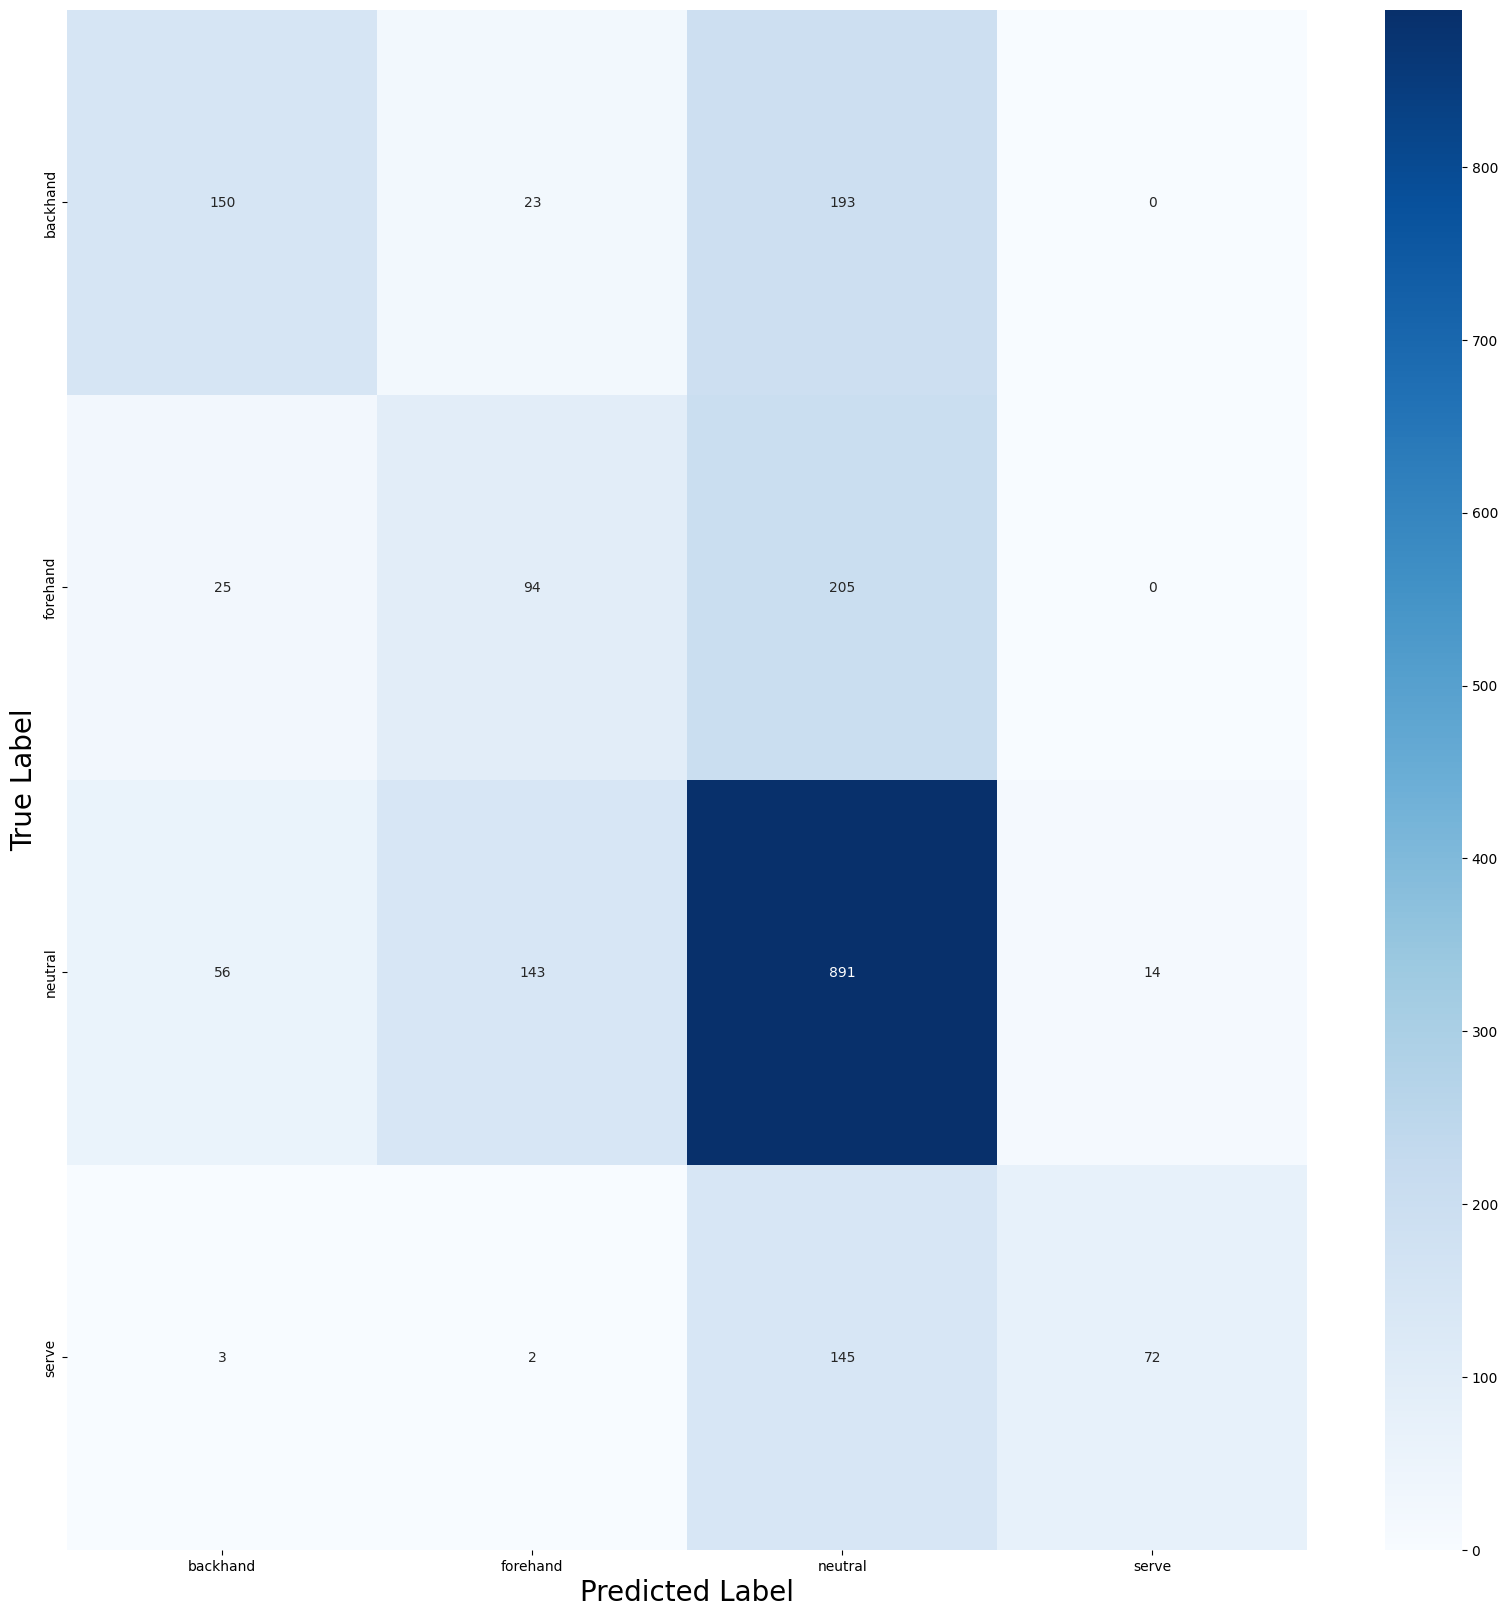

In [46]:
# Plot the confusion matrix
%matplotlib inline

cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_predictions)

df_cm = pd.DataFrame(
    cm, index=le.classes_, columns=le.classes_
)
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.show()